In [13]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                   Lambda, Input, Flatten, 
                                   Concatenate)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
# === Configuration ===
config = {
    "epochs": 30,
    "is_config_batch_size_param": True,
    "batch_size": 200,
    "initial_lr": 0.001,
    "gpu_memory_limit": 48,  
    "target_size": (480, 640),
    "input_shape": (640, 480, 3),
    "data_path": "Dataset/train_images",
    "csv_path": "processed_data/cleaned_imbalance_metadata.csv",
    "train_set_csv": "Result/training6_alex/training6_alex_train_set.csv",
    "val_set_csv": "Result/training6_alex/training6_alex_validation_set.csv",
    "best_model": "Result/training6_alex/training6_alex_best_model.keras",
    "label_encoder_path": "Result/training6_alex/training6_alex_label_encoder.npy",
    "color_channel": "",
    "save_dir": "Result/training6_alex",
}

In [15]:
# === GPU Setup ===
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)
        tf.config.threading.set_intra_op_parallelism_threads(8)
        tf.config.threading.set_inter_op_parallelism_threads(4)
    except RuntimeError as e:
        print(e)

def cleanup_gpu_memory():
    """Force clear GPU memory"""
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    if tf.config.list_physical_devices('GPU'):
        try:
            for gpu in tf.config.list_physical_devices('GPU'):
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass

In [16]:
# === Memory Management ===
def calculate_max_batch_size(model, input_shape, gpu_mem=24, default_batch=32, is_use_config_batch_size=config["is_config_batch_size_param"]):
    """Improved batch size calculator with error handling"""
    if is_use_config_batch_size:
        return default_batch
    try:
        params = model.count_params()
        
        last_dense = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Dense):
                last_dense = layer
                if layer.name == 'features':  
                    break
        
        if last_dense is None:
            raise ValueError("No Dense layer found in model!")
        
        # Memory per sample = weights + activations (in GB)
        per_sample = (
            (params * 4) +                 
            (np.prod(input_shape) * last_dense.units * 4)  
        ) / (1024 ** 3)
        
        # Max batch size with 3GB safety margin
        max_batch = int((gpu_mem - 3) / per_sample)
        return min(256, max_batch)  
    
    except Exception as e:
        print(f"Warning: Batch size estimation failed, using default={default_batch}. Error: {e}")
        return default_batch

In [17]:
# === Data Pipeline ===
def load_and_preprocess_data(random_state=42, save_splits=True):
    """Load and split data with fixed random state for reproducibility"""
    df = pd.read_csv(config["csv_path"])
    
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    print(f"Label classes: {le.classes_}")
    
    with open(config['label_encoder_path'], 'wb') as f:
        np.save(f, le.classes_)
    
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['label'],
        random_state=random_state,
    )
    
    if save_splits:
        train_df.to_csv(config['train_set_csv'], index=False)
        val_df.to_csv(config['val_set_csv'], index=False)
    
    return train_df, val_df, le

In [18]:
class DataGenerator(Sequence):
    def __init__(self, df, base_path, batch_size=32, target_size={config['target_size']}, shuffle=False, debug=False, input_config=None, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.batch_size = batch_size
        self.target_size = target_size  
        self.shuffle = shuffle
        self.debug = debug
        self.indices = np.arange(len(df))
        self.input_config = input_config
        
        self.aug = A.Compose(input_config["augmentation"])
        
        if shuffle:
            np.random.shuffle(self.indices)
            
        if self.debug:
            self.visualize_samples()    
            

    def visualize_samples(self):        
        try:
            row = self.df.iloc[0]
            img = self._load_image(row['image_id'], row['label'])
            augmented = self.aug(image=img)
            
            plt.figure(figsize=(12, 6))
            
            # original
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Original\nShape: {img.shape}")
            
            # augmented
            plt.subplot(1, 2, 2)
            plt.imshow(augmented['image'])
            plt.title(f"Augmented\nShape: {augmented['image'].shape}")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Visualization failed for {row['image_id']}: {str(e)}")
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def _load_image(self, image_id, label):
        img_path = os.path.join(
            self.base_path,
            label,
            f"{os.path.splitext(image_id)[0]}.jpg"
        )
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        return img
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.zeros((len(batch_df), self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
        y = np.zeros((len(batch_df),), dtype=np.int32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            try:
                img = self._load_image(row['image_id'], row['label'])
                augmented = self.aug(image=img)
                X[i] = augmented['image'] / 255.0
                y[i] = row['label_encoded']
            except Exception as e:
                print(f"Error loading {row['image_id']}: {str(e)}")
                X[i] = np.zeros((self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
                y[i] = -1
                
        valid = y != -1
        return X[valid], y[valid]

In [19]:
def create_alexnet(input_shape, num_classes):
    """Create AlexNet model without LRN"""
    inputs = Input(shape=input_shape, dtype=tf.float32)
    
    # Layer 1
    x = Conv2D(96, (11, 11), strides=4, activation='relu', padding='valid')(inputs)
    x = MaxPooling2D((3, 3), strides=2)(x)
    
    # Layer 2
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)
    
    # Layer 3
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    
    # Layer 4
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    
    # Layer 5
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)
    
    # Fully connected layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(num_classes, activation='softmax', dtype=tf.float32)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [20]:
# === Training ===
def train(config, best_model_path):
    cleanup_gpu_memory()
    
    try:
        train_df, val_df, le = load_and_preprocess_data(random_state=42)
        num_classes = len(le.classes_)
        print("Classes: ", num_classes)
        
        # Create the mopdel
        input_shape = config["input_shape"] 
        model = create_alexnet(input_shape, num_classes)
        
        # Find optimal batch size
        cleanup_gpu_memory()
        optimized_batch_size = calculate_max_batch_size(
                                    model, 
                                    input_shape=config["input_shape"],
                                    gpu_mem=config["gpu_memory_limit"],
                                    default_batch=config["batch_size"],
                                )
        
        print(f"\n=== Training Configuration ===")
        print(f"Batch size: {optimized_batch_size}")
        print(f"Input size: {config['target_size']}")
        print(f"Classes: {num_classes}")
        print(f"GPU Memory: {config['gpu_memory_limit']}GB\n")
        print(f"Model input shape: {model.input_shape}")
        
        train_gen = DataGenerator(
            df=train_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,
            target_size=config["target_size"],
            shuffle=False,
            debug=True,
            input_config=config
        )
        
        val_gen = DataGenerator(
            df=val_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,
            target_size=config["target_size"],
            shuffle=False,
            debug=False,
            input_config=config
        )
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        sample_batch = train_gen[0]
        print(f"Generator output shape: {sample_batch[0].shape}")
        print(f"Model input shape: {model.input_shape}")
        
        # Train
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=config["epochs"],
            callbacks=[
                    tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=5,  
                    mode='max',
                    restore_best_weights=True  
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    best_model_path,  
                    save_weights_only=False,
                    monitor='val_accuracy',
                    save_best_only=True
                ),
                    tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy',
                    factor=0.5,  
                    patience=3,
                    mode='max'
                )
            ]
        )
        
        return model, history
        
    except Exception as e:
        print(f"Training failed: {e}")
        cleanup_gpu_memory()
        raise

In [21]:
def plot_accuracy_loss(history):
    """Plot accuracy and loss"""
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [22]:
def evaluate_model(config, best_model_path, use_val_set=True):
    """Deterministic evaluation with debug checks"""
    try:
        # Load model 
        with open(config['label_encoder_path'], 'rb') as f:
            classes = np.load(f, allow_pickle=True)
        le = LabelEncoder()
        le.classes_ = classes

        model = tf.keras.models.load_model(best_model_path, compile=False) 
            
        cleanup_gpu_memory()
        optimized_batch_size = calculate_max_batch_size(
                                    model, 
                                    input_shape=config["input_shape"],
                                    gpu_mem=config["gpu_memory_limit"],
                                    default_batch=config["batch_size"],
                                )
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')
            ]
        )

        eval_df = pd.read_csv(config["val_set_csv"]) if use_val_set else load_and_preprocess_data(save_splits=False)[1]
        print(f"Evaluating on {len(eval_df)} samples")

        eval_gen = DataGenerator(
            df=eval_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,  
            target_size=config["target_size"],
            shuffle=False,  
            debug=False,
            input_config=config
        )

        # Inspect first batch
        x_test, y_test = eval_gen[0]
        print(f"\n[DEBUG] First batch - X shape: {x_test.shape}, y shape: {y_test.shape}")
        print(f"[DEBUG] Sample label: {y_test[0]} -> {le.classes_[y_test[0]]}")

        # Standard evaluation
        results = model.evaluate(eval_gen, verbose=1, return_dict=True)
        print("\n[METRICS] Evaluation Results:", results)

        # Collect predictions
        y_true, y_pred = [], []
        for i in range(len(eval_gen)):
            x, y = eval_gen[i]
            y_true.extend(y)
            y_pred.extend(model.predict(x, verbose=0).argmax(axis=1))
        
        # Plot confusion matrix
        plot_confusion_matrix(y_true, y_pred, le.classes_, normalize=True)
        
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=le.classes_))

        return results

    except Exception as e:
        print(f"Evaluation failed: {e}")
        raise
    
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    fmt = '.2f' if normalize else 'd'
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, xticklabels=classes, yticklabels=classes,
                cmap='Blues', cbar=False)
    plt.title(title or 'Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


Label classes: ['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']
Classes:  10

=== Training Configuration ===
Batch size: 200
Input size: (255, 255)
Classes: 10
GPU Memory: 48GB

Model input shape: (None, 255, 255, 3)


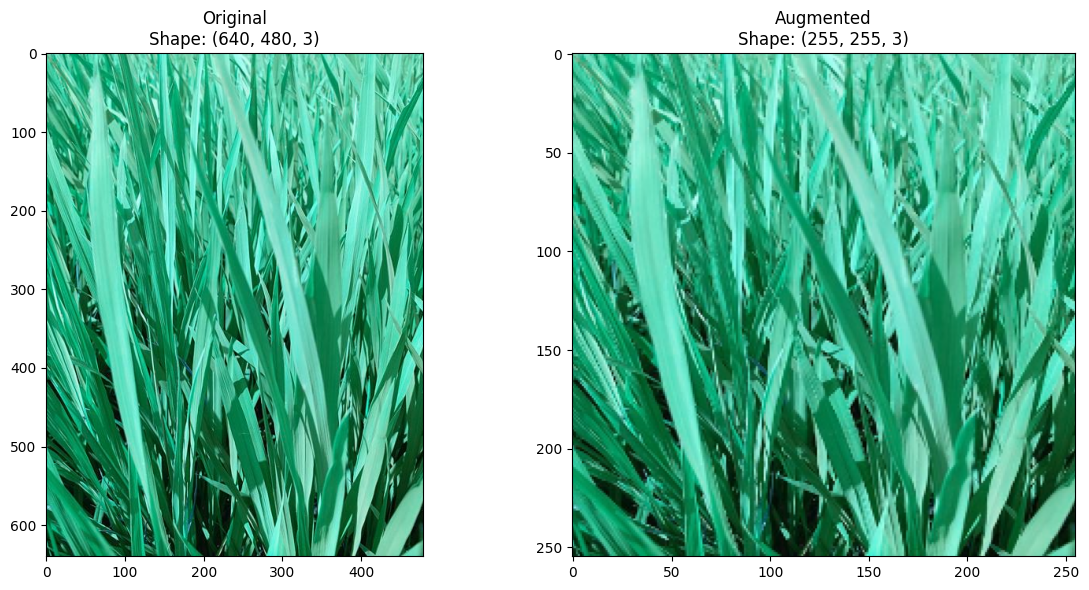

Generator output shape: (200, 255, 255, 3)
Model input shape: (None, 255, 255, 3)
Epoch 1/30


W0000 00:00:1747352273.955108    7277 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 [==============================] - ETA: 0s - loss: 2.3962 - accuracy: 0.1651WARNING:tensorflow:5 out of the last 15 calls to <function Model.make_test_function.<locals>.test_function at 0x78f9c011aca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


W0000 00:00:1747352302.326143    7279 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 [==============================] - 50s 895ms/step - loss: 2.3962 - accuracy: 0.1651 - val_loss: 2.1667 - val_accuracy: 0.1710 - lr: 0.0010
Epoch 2/30
27/41 [==================>...........] - ETA: 13s - loss: 2.1600 - accuracy: 0.1737

W0000 00:00:1747352336.075508    7277 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 [==============================] - 40s 984ms/step - loss: 2.1645 - accuracy: 0.1691 - val_loss: 2.1609 - val_accuracy: 0.1710 - lr: 0.0010
Epoch 3/30
41/41 [==============================] - 31s 762ms/step - loss: 2.1631 - accuracy: 0.1629 - val_loss: 2.1603 - val_accuracy: 0.1671 - lr: 0.0010
Epoch 4/30
41/41 [==============================] - 31s 758ms/step - loss: 2.1628 - accuracy: 0.1685 - val_loss: 2.1481 - val_accuracy: 0.1671 - lr: 0.0010
Epoch 5/30
41/41 [==============================] - 36s 870ms/step - loss: 2.1489 - accuracy: 0.1825 - val_loss: 2.1068 - val_accuracy: 0.2122 - lr: 5.0000e-04
Epoch 6/30
41/41 [==============================] - 33s 807ms/step - loss: 2.0991 - accuracy: 0.2216 - val_loss: 2.0649 - val_accuracy: 0.2391 - lr: 5.0000e-04
Epoch 7/30
41/41 [==============================] - 33s 798ms/step - loss: 2.0668 - accuracy: 0.2322 - val_loss: 2.0265 - val_accuracy: 0.2489 - lr: 5.0000e-04
Epoch 8/30
41/41 [==============================] - 37s 916ms/s

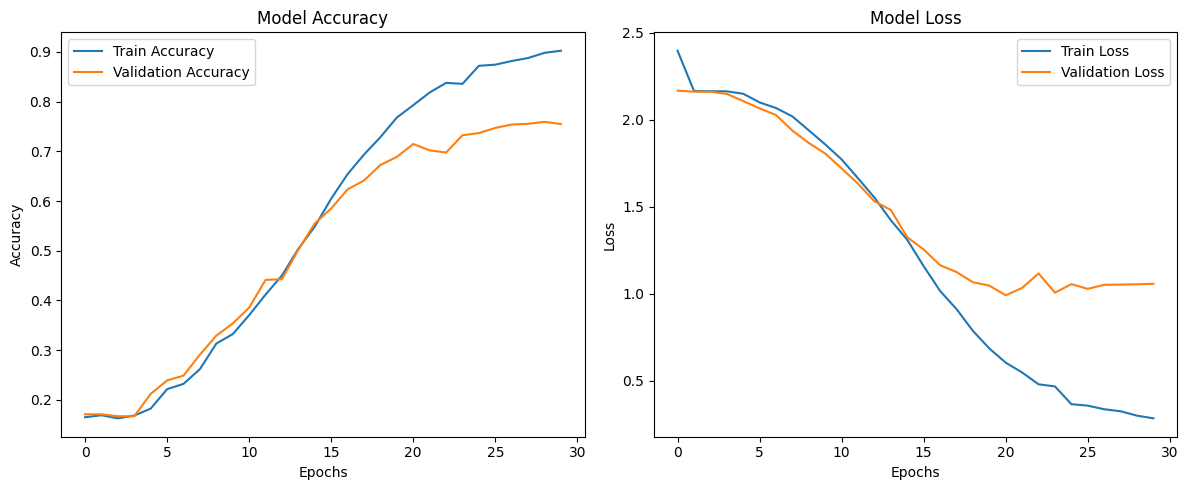

Evaluating on 2041 samples

[DEBUG] First batch - X shape: (200, 255, 255, 3), y shape: (200,)
[DEBUG] Sample label: 5 -> dead_heart
 1/11 [=>............................] - ETA: 13s - loss: 1.0150 - acc: 0.7500 - top3_acc: 0.9250

W0000 00:00:1747353280.375905    7276 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 [==============================] - 6s 501ms/step - loss: 1.0537 - acc: 0.7594 - top3_acc: 0.8951

[METRICS] Evaluation Results: {'loss': 1.053746223449707, 'acc': 0.7594316601753235, 'top3_acc': 0.8951494097709656}


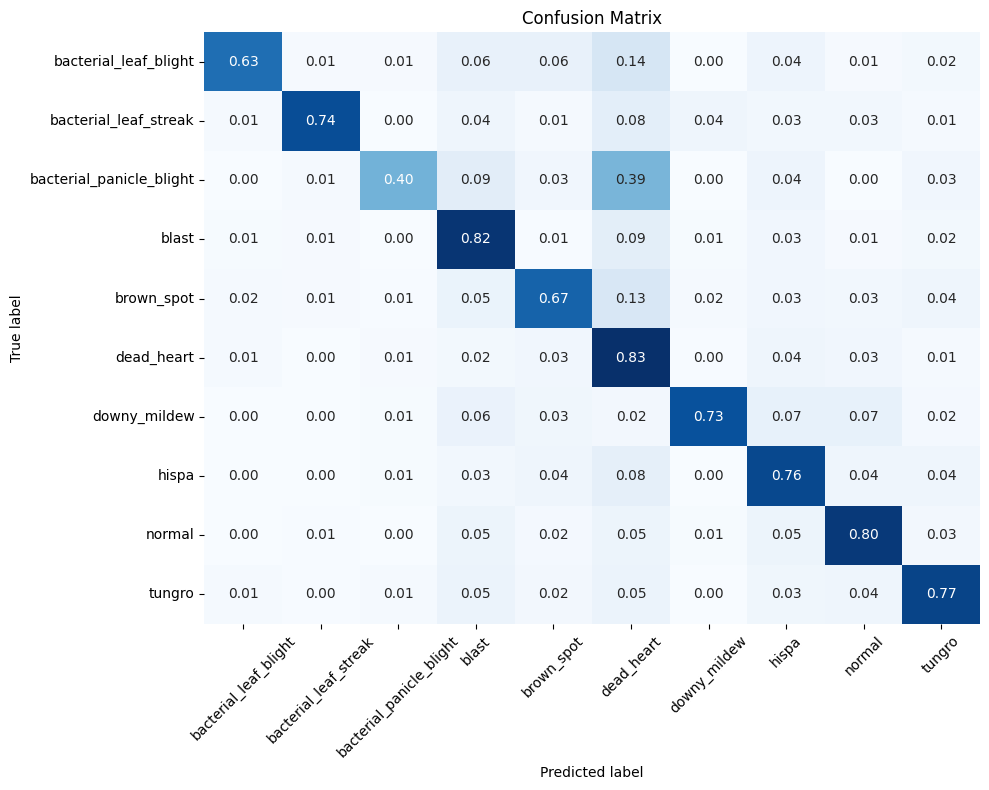


Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.80      0.63      0.71        93
   bacterial_leaf_streak       0.82      0.74      0.78        73
bacterial_panicle_blight       0.68      0.40      0.50        67
                   blast       0.79      0.82      0.80       341
              brown_spot       0.72      0.67      0.70       188
              dead_heart       0.61      0.83      0.70       283
            downy_mildew       0.86      0.73      0.79       122
                   hispa       0.78      0.76      0.77       311
                  normal       0.85      0.80      0.83       349
                  tungro       0.78      0.77      0.78       214

                accuracy                           0.76      2041
               macro avg       0.77      0.72      0.74      2041
            weighted avg       0.77      0.76      0.76      2041



In [23]:
config_1 = {**config, "target_size": (255, 255), "input_shape": (255, 255, 3), "augmentation": [A.Resize(width=255, height=255),]}

best_model_dir_1 = os.path.join(config_1["save_dir"], "best_1.keras")
model_1, history_1 = train(config_1, best_model_dir_1)
plot_accuracy_loss(history_1)
evaluate_model(config_1, best_model_dir_1, use_val_set=True)

history_dir_1 = os.path.join(config_1["save_dir"], "history_1.csv")
history_df_1 = pd.DataFrame(history_1.history)
history_df_1.to_csv(history_dir_1, index=False)

Label classes: ['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']
Classes:  10

=== Training Configuration ===
Batch size: 200
Input size: (480, 640)
Classes: 10
GPU Memory: 48GB

Model input shape: (None, 640, 480, 3)


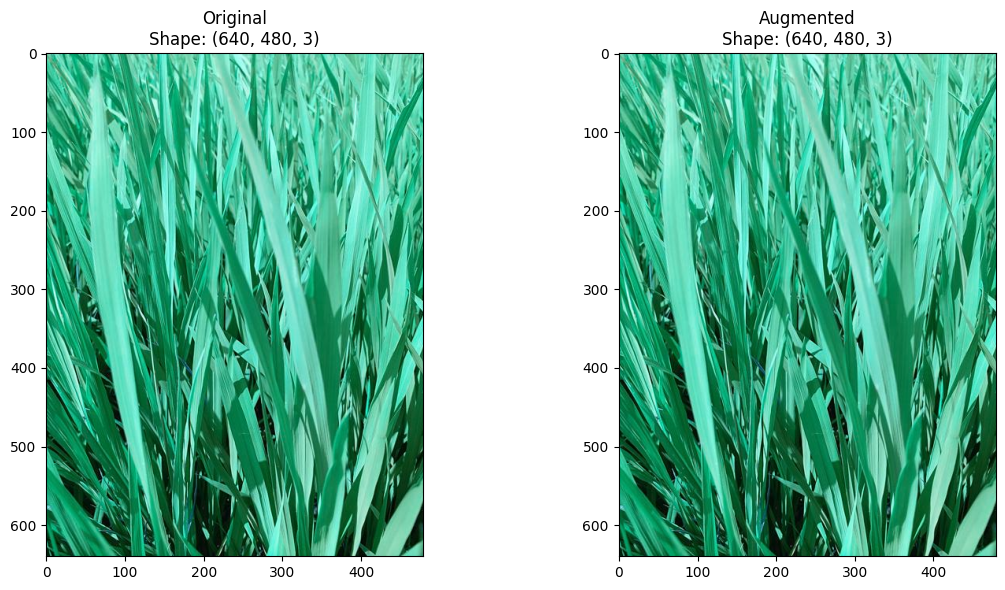

Generator output shape: (200, 640, 480, 3)
Model input shape: (None, 640, 480, 3)


Epoch 1/30


2025-05-15 23:55:53.267143: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[96,3,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[200,3,640,480]{3,2,1,0}, f32[200,96,158,118]{3,2,1,0}), window={size=11x11 stride=4x4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2025-05-15 23:55:53.512619: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.245601146s
Trying algorithm eng0{} for conv (f32[96,3,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[200,3,640,480]{3,2,1,0}, f32[200,96,158,118]{3,2,1,0}), window={size=11x11 stride=4x4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2025-05-15 23:55:56.335977: E ext

41/41 [==============================] - ETA: 0s - loss: 3.9813 - accuracy: 0.1614

W0000 00:00:1747353468.443363    7279 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 [==============================] - 206s 4s/step - loss: 3.9813 - accuracy: 0.1614 - val_loss: 2.1617 - val_accuracy: 0.1710 - lr: 0.0010
Epoch 2/30
11/41 [=======>......................] - ETA: 3:10 - loss: 2.1503 - accuracy: 0.1838

W0000 00:00:1747353571.597580    7276 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 [==============================] - 152s 4s/step - loss: 2.1583 - accuracy: 0.1841 - val_loss: 2.1188 - val_accuracy: 0.2469 - lr: 0.0010
Epoch 3/30
41/41 [==============================] - 135s 3s/step - loss: 2.0595 - accuracy: 0.2765 - val_loss: 2.0165 - val_accuracy: 0.2719 - lr: 0.0010
Epoch 4/30
41/41 [==============================] - 132s 3s/step - loss: 1.8499 - accuracy: 0.3610 - val_loss: 1.7598 - val_accuracy: 0.4003 - lr: 0.0010
Epoch 5/30
41/41 [==============================] - 132s 3s/step - loss: 1.7019 - accuracy: 0.4134 - val_loss: 1.5082 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 6/30
41/41 [==============================] - 132s 3s/step - loss: 1.4368 - accuracy: 0.5205 - val_loss: 1.3291 - val_accuracy: 0.5404 - lr: 0.0010
Epoch 7/30
41/41 [==============================] - 134s 3s/step - loss: 1.2222 - accuracy: 0.5925 - val_loss: 1.1033 - val_accuracy: 0.6384 - lr: 0.0010
Epoch 8/30
41/41 [==============================] - 132s 3s/step - loss: 0.9750 - accur

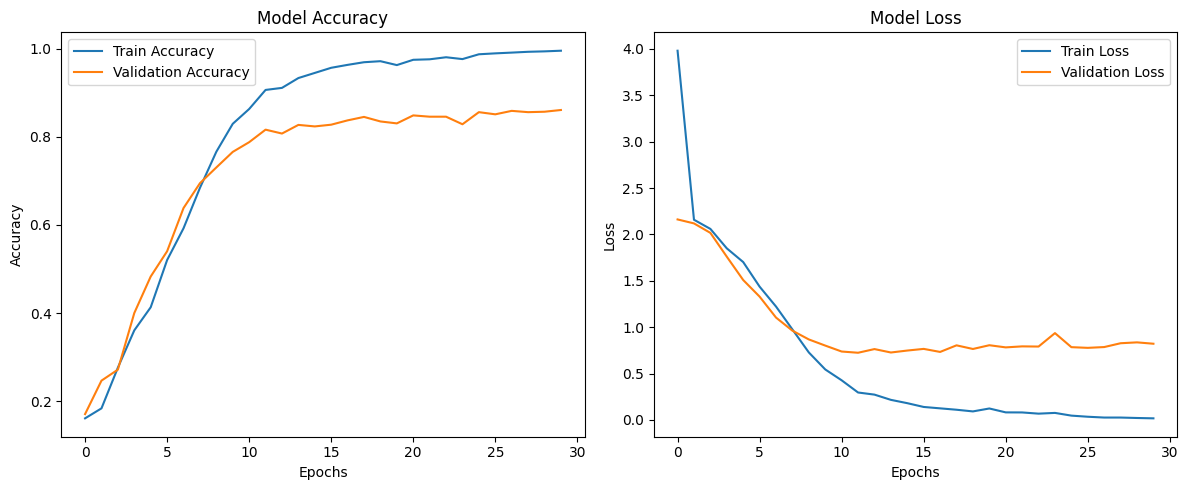

Evaluating on 2041 samples

[DEBUG] First batch - X shape: (200, 640, 480, 3), y shape: (200,)
[DEBUG] Sample label: 5 -> dead_heart
 1/11 [=>............................] - ETA: 24s - loss: 0.7478 - acc: 0.8450 - top3_acc: 0.9650

W0000 00:00:1747360793.685069    7277 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 [==============================] - 19s 2s/step - loss: 0.8211 - acc: 0.8609 - top3_acc: 0.9544

[METRICS] Evaluation Results: {'loss': 0.8211260437965393, 'acc': 0.8608525395393372, 'top3_acc': 0.9544340968132019}


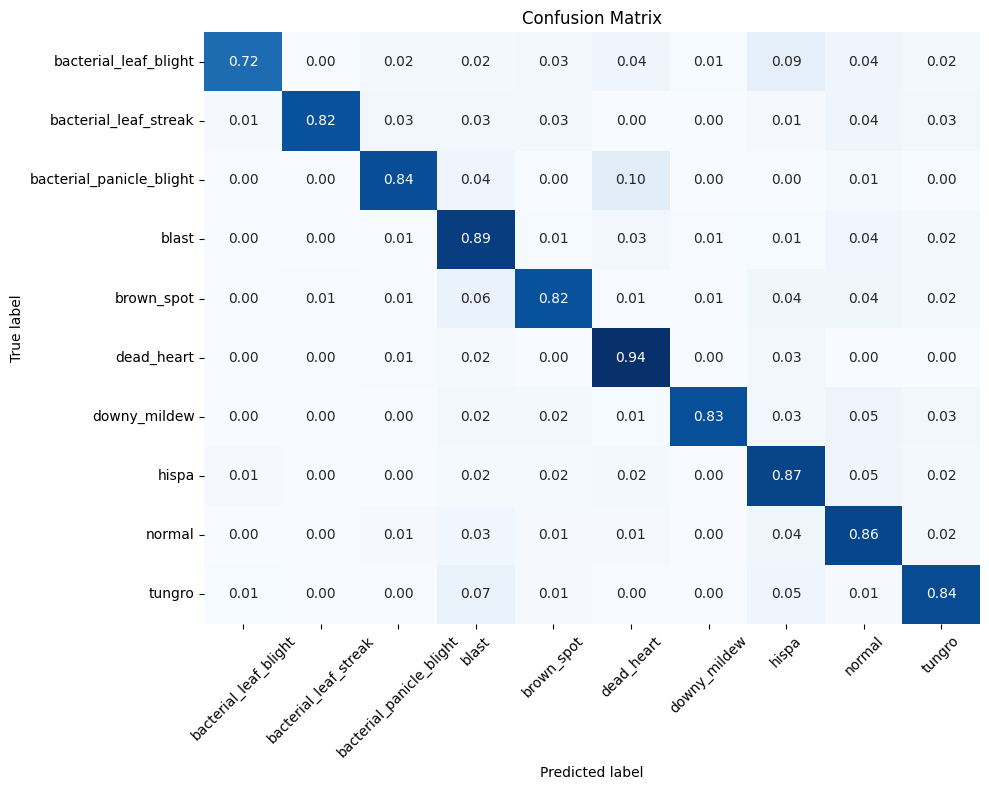


Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.88      0.72      0.79        93
   bacterial_leaf_streak       0.98      0.82      0.90        73
bacterial_panicle_blight       0.80      0.84      0.82        67
                   blast       0.84      0.89      0.86       341
              brown_spot       0.87      0.82      0.84       188
              dead_heart       0.89      0.94      0.91       283
            downy_mildew       0.95      0.83      0.89       122
                   hispa       0.83      0.87      0.85       311
                  normal       0.85      0.86      0.86       349
                  tungro       0.84      0.84      0.84       214

                accuracy                           0.86      2041
               macro avg       0.87      0.84      0.86      2041
            weighted avg       0.86      0.86      0.86      2041



In [24]:
config_2 = {**config, "augmentation": [A.Resize(width=480, height=640),]}

best_model_dir_2 = os.path.join(config_2["save_dir"], "best_2.keras")
model_2, history_2 = train(config_2, best_model_dir_2)
plot_accuracy_loss(history_2)
evaluate_model(config_2, best_model_dir_2, use_val_set=True)

history_dir_2 = os.path.join(config_2["save_dir"], "history_2.csv")
history_df_2 = pd.DataFrame(history_2.history)
history_df_2.to_csv(history_dir_2, index=False)